# Imports

In [32]:
#cropping imports
import os
import cv2
import torch
from torch.utils.data import Dataset

In [33]:
#preprocessing imports
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

In [34]:
#GAN imports
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

In [35]:
# Model imports
import torch.nn as nn
import torchvision.transforms.functional as TF

from torchsummary import summary

In [208]:
#Training imports
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from itertools import product
import sys

In [37]:
#Training visualization imports
import cv2

In [38]:
#Graph imports
import numpy as np
import matplotlib.pyplot as plt

In [39]:
#Test imports
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
import random

# Preprocessing
### Cropping

In [34]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import cv2

class TumorDataset(Dataset):
    def __init__(self, root_dir, save_dir, apply_cropping=True, transform=None):
        """
        Args:
            root_dir (str): Path to the dataset directory with .npy files.
            save_dir (str): Path to save processed .npy files.
            apply_cropping (bool): Whether to apply cropping.
            transform (callable, optional): Optional transform for the images.
        """
        self.root_dir = root_dir
        self.save_dir = save_dir
        self.apply_cropping = apply_cropping
        self.transform = transform
        self.data = []  # Stores (image_path, mask_path, save_img_path, save_mask_path)

        # Defining paths for .npy files
        img_dir = os.path.join(self.root_dir, "images")
        mask_dir = os.path.join(self.root_dir, "masks")
        save_img_dir = os.path.join(self.save_dir, "images")
        save_mask_dir = os.path.join(self.save_dir, "masks")

        # Create save directories
        os.makedirs(save_img_dir, exist_ok=True)
        os.makedirs(save_mask_dir, exist_ok=True)

        # Get all .npy files
        img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.npy')])[:4000]
        mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.npy')])[:4000]

        print(f"Total images found in dataset: {len(img_files)}, Total masks found: {len(mask_files)}")

        # Match images and masks
        for img_name in img_files:
            img_path = os.path.join(img_dir, img_name)
            mask_path = os.path.join(mask_dir, img_name)

            save_img_path = os.path.join(save_img_dir, img_name)
            save_mask_path = os.path.join(save_mask_dir, img_name)

            if os.path.exists(mask_path):
                self.data.append((img_path, mask_path, save_img_path, save_mask_path))
            else:
                print(f"Warning: No corresponding mask found for {img_name}")

    def crop_image_and_mask(self, img, mask):
        """Applies cropping based on the tumor region, keeping original resolution."""
        # Convert to uint8 for OpenCV operations
        img_uint8 = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
        _, thresh = cv2.threshold(img_uint8, 40, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            c = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(c)
            
            # Apply cropping to both image and mask
            img = img[y:y+h, x:x+w]
            mask = mask[y:y+h, x:x+w]

        return img, mask

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, mask_path, save_img_path, save_mask_path = self.data[idx]
        
        # Load .npy files
        img = np.load(img_path)
        mask = np.load(mask_path)

        if img is None or mask is None:
            print(f"Warning: Could not load image or mask for {img_path}")
            return None

        if self.apply_cropping:
            img, mask = self.crop_image_and_mask(img, mask)

        # Save processed image and mask as .npy files
        np.save(save_img_path, img)
        np.save(save_mask_path, mask)

        # Convert to PyTorch tensors
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        
        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, mask_tensor

# ------------------------------
# Applying preprocessing to all images
# ------------------------------
dataset_path = "/kaggle/input/brats-preprocessed-256/training"
crop_path = "cropped_images/"

# Check if dataset exists
print("Dataset exists:", os.path.exists(dataset_path))

# List contents of dataset directory
print("Contents:", os.listdir(dataset_path))

# Initialize dataset
dataset = TumorDataset(root_dir=dataset_path, save_dir=crop_path, apply_cropping=True)

# Process all images
for i in range(len(dataset)):
    sample = dataset[i]
    if sample is not None:
        print(f"Processed {i+1}/{len(dataset)} images", end="\r")

print("\nProcessing complete!")

Dataset exists: True
Contents: ['images', 'masks']
Total images found in dataset: 4000, Total masks found: 4000


KeyboardInterrupt: 

In [ ]:
import zipfile

def zip_directory(folder_path, output_path):
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, start=folder_path)
                zipf.write(file_path, arcname)

# Example usage:
zip_path = "/kaggle/working/braTS_cropped_256.zip"
zip_directory(crop_path, zip_path)
print(f"Zipped to: {zip_path}")

In [ ]:
print(f"Total cropped images found: {len(os.listdir(os.path.join(crop_path,'images')))}, Total cropped masks found: {len(os.listdir(os.path.join(crop_path,'masks')))}")

### Data augmentation and resizing

#### train-test-val split

In [40]:
def train_val_test_split(images, masks, val_size=0.15, test_size=0.15, random_state=None):
    """
    Splits images and masks into train, validation, and test sets while maintaining correspondence.

    Args:
        images (list): List of image file paths or image data.
        masks (list): List of corresponding mask file paths or mask data.
        val_size (float): Proportion of samples for the validation set.
        test_size (float): Proportion of samples for the test set.
        random_state (int, optional): Random seed for reproducibility.

    Returns:
        tuple: (train_images, val_images, test_images, train_masks, val_masks, test_masks)
    """
    assert len(images) == len(masks), "Images and masks must have the same length."

    if random_state is not None:
        np.random.seed(random_state)

    total_samples = len(images)
    val_count = math.ceil(val_size * total_samples)
    test_count = math.ceil(test_size * total_samples)
    train_count = total_samples - val_count - test_count

    indices = np.arange(total_samples)
    np.random.shuffle(indices)

    train_indices = indices[:train_count]
    val_indices = indices[train_count:train_count + val_count]
    test_indices = indices[train_count + val_count:]

    train_images = [images[i] for i in train_indices]
    val_images = [images[i] for i in val_indices]
    test_images = [images[i] for i in test_indices]

    train_masks = [masks[i] for i in train_indices]
    val_masks = [masks[i] for i in val_indices]
    test_masks = [masks[i] for i in test_indices]

    return train_images, val_images, test_images, train_masks, val_masks, test_masks

In [41]:
# -----------------------
# Define Paths
# -----------------------
image_path = "/kaggle/input/cropped-images/images"
mask_path = "/kaggle/input/cropped-images/masks"

images = sorted(os.listdir(image_path))
masks = sorted(os.listdir(mask_path))

train_imgs, val_imgs, test_imgs, train_masks, val_masks, test_masks = train_val_test_split(images, masks, val_size=0.03, test_size=0.95, random_state=42)
#val_imgs, test_imgs, val_masks, test_masks = train_test_split(test_imgs, test_masks, test_size=0.5, random_state=42)

print("No of train images = ",len(train_imgs))
print("No of validation images = ",len(val_imgs))
print("No of test images = ",len(test_imgs))

No of train images =  451
No of validation images =  679
No of test images =  21481


# GAN

In [42]:
# config.py
# Paths
DATA_DIR = "/kaggle/input/cropped-images"  # Replace with actual data directory
SAVE_DIR = "/kaggle/working/GAN_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)
MODEL_SAVE_DIR = os.path.join(SAVE_DIR, "models")
GEN_SAVE_DIR = os.path.join(SAVE_DIR, "generated_images")
GEN_IMG_SAVE_DIR = os.path.join(GEN_SAVE_DIR, "images")
GEN_MASK_SAVE_DIR = os.path.join(GEN_SAVE_DIR, "masks")
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(GEN_SAVE_DIR, exist_ok=True)
os.makedirs(GEN_IMG_SAVE_DIR, exist_ok=True)
os.makedirs(GEN_MASK_SAVE_DIR, exist_ok=True)

# Training Parameters
IMG_SIZE = 256
IN_CHANNELS = 1
OUT_CHANNELS = 1
BATCH_SIZE = 1
LR = 2e-4
NUM_EPOCHS = 150
LAMBDA_L1 = 100  # For L1 loss in generator
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [43]:
class BrainMRIDataset(Dataset):
    def __init__(self, image_names, mask_names, image_dir, mask_dir):
        """
        Args:
            image_names (list): List of image filenames (e.g., "2115.png")
            mask_names (list): List of corresponding mask filenames
            image_dir (str): Directory containing images
            mask_dir (str): Directory containing masks
        """
        self.image_names = image_names
        self.mask_names = mask_names
        self.image_dir = image_dir
        self.mask_dir = mask_dir    
        
        # Verify the lists match
        assert len(self.image_names) == len(self.mask_names), \
               "Number of images and masks must match"
        
        # Verify files exist
        for img_name, mask_name in zip(self.image_names, self.mask_names):
            img_path = os.path.join(image_dir, img_name)
            mask_path = os.path.join(mask_dir, mask_name)
            assert os.path.exists(img_path), f"Image not found: {img_path}"
            assert os.path.exists(mask_path), f"Mask not found: {mask_path}"
        
        # Transforms
        self.image_transform = transforms.Compose([
            transforms.Resize((256, 256),),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))  # Images to [-1, 1]
        ])
        
        self.mask_transform = transforms.Compose([
            transforms.Resize((256, 256),interpolation=Image.NEAREST),
            #transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()  # Masks to [0, 1]
        ])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_names[idx])

        def load_image(img : np.ndarray):
            arr = (255 * img).astype(np.uint8)
            return Image.fromarray(arr).convert("L")
        image = load_image(np.load(img_path))
        mask = load_image(np.load(mask_path))
    
        image = self.image_transform(image)
        mask = self.mask_transform(mask)
        
        #print("Mask shape after transform:", mask.shape, "Unique values:", np.unique(mask.squeeze().detach().cpu().numpy()))
    
        return image, mask

In [44]:
import torch
import torch.nn as nn
from torchsummary import summary

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=64):
        super(UNetGenerator, self).__init__()

        def down(in_c, out_c, normalize=True):
            layers = [nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def up(in_c, out_c, dropout=0.0):
            layers = [
                nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            ]
            if dropout:
                layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        # Downsampling
        self.down1 = down(in_channels, features, normalize=False)  # 256→128
        self.down2 = down(features, features * 2)                  # 128→64
        self.down3 = down(features * 2, features * 4)              # 64→32
        self.down4 = down(features * 4, features * 8)              # 32→16
        self.down5 = down(features * 8, features * 8)              # 16→8
        self.down6 = down(features * 8, features * 8)              # 8→4
        self.down7 = down(features * 8, features * 8)              # 4→2
        self.down8 = down(features * 8, features * 8, normalize=False)  # 2→1

        # Upsampling
        self.up1 = up(features * 8, features * 8, dropout=0.5)     # 1→2
        self.up2 = up(features * 16, features * 8, dropout=0.5)    # 2→4
        self.up3 = up(features * 16, features * 8, dropout=0.5)    # 4→8
        self.up4 = up(features * 16, features * 8)                 # 8→16
        self.up5 = up(features * 16, features * 4)                 # 16→32
        self.up6 = up(features * 8, features * 2)                  # 32→64
        self.up7 = up(features * 4, features)                      # 64→128
        self.up8 = nn.Sequential(                                  # 128→256
            nn.ConvTranspose2d(features * 2, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], dim=1))
        u3 = self.up3(torch.cat([u2, d6], dim=1))
        u4 = self.up4(torch.cat([u3, d5], dim=1))
        u5 = self.up5(torch.cat([u4, d4], dim=1))
        u6 = self.up6(torch.cat([u5, d3], dim=1))
        u7 = self.up7(torch.cat([u6, d2], dim=1))
        return self.up8(torch.cat([u7, d1], dim=1))

# === Test ===
def test():
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNetGenerator().to(DEVICE)
    x = torch.randn((3, 1, 256, 256)).to(DEVICE)
    preds = model(x)
    print(f"Input shape = {x.shape}")
    print(f"Output shape = {preds.shape}")
    print(f"Generator Model Summary:")
    summary(model, (1, 256, 256))

if __name__ == "__main__":
    test()


Input shape = torch.Size([3, 1, 256, 256])
Output shape = torch.Size([3, 1, 256, 256])
Generator Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,024
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 512, 8, 8]       4

In [45]:
import torch
import torch.nn as nn
from torchsummary import summary

class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=2, features=64):
        super(PatchDiscriminator, self).__init__()

        def block(in_c, out_c, normalize=True, stride=2, padding=1):
            layers = [nn.Conv2d(in_c, out_c, 4, stride, padding, bias=False)]  # Kernel size 4, stride 2, padding 1
            if normalize:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        self.model = nn.Sequential(
            *block(in_channels, features, normalize=False, stride=2),     # 256 → 128
            *block(features, features*2, stride=2),                        # 128 → 64
            *block(features*2, features*4, stride=2),                      # 64 → 32
            *block(features*4, features*8, stride=1),                      # 32 → 31
            nn.Conv2d(features*8, 1, 4, stride=1, padding=1)  # 31 → 30 (Patch size)
        )

    def forward(self, x, y):
        # Concatenate input and target images along the channel dimension
        return self.model(torch.cat([x, y], dim=1))

def test():
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Create a random input tensor for MRI images (size: 256x256 with 1 channel)
    x = torch.randn((3, 1, 256, 256)).to(DEVICE)  # MRI image batch (size 3, 1 channel, 256x256)

    # Create a random input tensor for the corresponding masks (size: 256x256 with 1 channel)
    y = torch.randn((3, 1, 256, 256)).to(DEVICE)  # Mask batch (size 3, 1 channel, 256x256)

    # Instantiate the PatchDiscriminator model
    model = PatchDiscriminator(in_channels=2, features=64).to(DEVICE)

    # Print the model summary
    print(f"Discriminator Model Summary:")
    summary(model, [(1, 256, 256), (1, 256, 256)])  # Pass both inputs for the summary

    # Pass the image (x) and mask (y) through the discriminator
    preds = model(x, y)

    # Print the shapes of the ininterpolation=Image.NEARESTputs and output
    print(f"Input image shape = {x.shape}")
    print(f"Input mask shape = {y.shape}")
    print(f"Discriminator output shape = {preds.shape}")

if __name__ == "__main__":
    test()


Discriminator Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           2,048
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 31, 31]       2,097,152
      BatchNorm2d-10          [-1, 512, 31, 31]           1,024
        LeakyReLU-11          [-1, 512, 31, 31]               0
           Conv2d-12            [-1, 1, 30, 30]           8,193
Total params: 2,764,545
Trainable params: 2,764,545
Non-trainable params: 

In [29]:
# # losses
# def dice_score(pred, target, smooth=1e-6):
#     pred = (pred > 0.5).float()  # Changed threshold to 0.5 for [0,1] range
#     target = (target > 0.5).float()
#     intersection = (pred * target).sum(dim=(1,2,3))
#     union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
#     return ((2.*intersection + smooth)/(union + smooth)).mean()

# def iou_score(pred, target, smooth=1e-6):
#     pred = (pred > 0.5).float()
#     target = (target > 0.5).float()
#     intersection = (pred * target).sum(dim=(1,2,3))
#     union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - intersection
#     return ((intersection + smooth)/(union + smooth)).mean()

In [46]:
generator = UNetGenerator().to(DEVICE)
discriminator = PatchDiscriminator().to(DEVICE)

g_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))

criterion_GAN = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()
mse_loss = nn.MSELoss()

In [47]:
mask_dir = os.path.join(DATA_DIR, "masks")
image_dir = os.path.join(DATA_DIR, "images")

train_dataset = BrainMRIDataset(train_imgs, train_masks, image_dir, mask_dir)
val_dataset = BrainMRIDataset(val_imgs, val_masks, image_dir, mask_dir)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
def init_weights_gaussian(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        if model.bias is not None:
            nn.init.constant_(model.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)


def show_samples(sample_x, sample_pred, sample_gt, epoch, g_loss):
    fig, axes = plt.subplots(1, 3, figsize=(6, 3),squeeze=False)
    axes = axes.reshape(1,3)
    for i in range(min(4,sample_x.shape[0])):
        axes[i, 0].imshow(sample_x[i].squeeze().numpy(), cmap="gray")
        axes[i, 0].set_title("Input")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(sample_pred[i].squeeze().numpy(), cmap="gray")
        axes[i, 1].set_title("Predicted")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(sample_gt[i].squeeze().numpy(), cmap="gray")
        axes[i, 2].set_title("Ground Truth")
        axes[i, 2].axis("off")

    plt.suptitle(f"Epoch {epoch+1} Samples : {g_loss}")
    plt.tight_layout()
    plt.show()


def plot_current_losses(g_losses, d_losses, epoch):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 8x4 for each plot side-by-side

    axs[0].plot(g_losses, label="Generator Loss", color="blue")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_title(f"Generator Loss (up to Epoch {epoch + 1})")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(d_losses, label="Discriminator Loss", color="red")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].set_title(f"Discriminator Loss (up to Epoch {epoch + 1})")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# MRI to MASK

In [ ]:
LOAD_MODEL = False  # or False, depending if you want to resume
LOAD_MODEL_PATH = "/kaggle/input/checkpoint_epoch_24_mask2mri/pytorch/default/1/checkpoint_epoch_24.pth"

# === Weight Initialization ===
generator.apply(init_weights_gaussian)
discriminator.apply(init_weights_gaussian)

# === Resume Setup ===
loss_history = {"g_loss": [], "d_loss": [], "mse": []}
start_epoch = 0
least_loss = 999

if LOAD_MODEL and os.path.exists(LOAD_MODEL_PATH):
    checkpoint = torch.load(LOAD_MODEL_PATH, map_location=DEVICE)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
    d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
    start_epoch = checkpoint['epoch']

# === Training Loop ===
for epoch in range(start_epoch, NUM_EPOCHS):
    generator.train()
    discriminator.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    running_g_loss = running_d_loss = running_mse = 0

    for batch_idx, (x,y) in enumerate(pbar):
        x, y = x.to(DEVICE), y.to(DEVICE)

        # === Discriminator Step ===
        fake_y = generator(x)
        real_out = discriminator(x, y)
        fake_out = discriminator(x, fake_y.detach())

        d_loss_real = criterion_GAN(real_out, torch.ones_like(real_out))
        d_loss_fake = criterion_GAN(fake_out, torch.zeros_like(fake_out))
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Generator Step ===
        fake_out = discriminator(x, fake_y)
        adv_loss = criterion_GAN(fake_out, torch.ones_like(fake_out))
        recon_loss = l1_loss(fake_y, y)
        g_loss = adv_loss + LAMBDA_L1 * recon_loss

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # === Metrics ===
        mse = mse_loss(fake_y, y)

        running_g_loss += g_loss.item()
        running_d_loss += d_loss.item()
        running_mse += mse.item()
        
        pbar.set_postfix({
            "D_Loss": f"{running_d_loss / (batch_idx+1):.4f}",
            "G_Loss": f"{running_g_loss / (batch_idx+1):.4f}",
            "MSE":    f"{running_mse / (batch_idx+1):.4f}",
        })

    
    print(f"\nG_loss for {epoch+1} : {g_loss}")
    # === Save Sample Outputs ===
    generator.eval()
    val_batch = next(iter(val_loader))
    val_x, val_y = val_batch[1].to(DEVICE), val_batch[0].to(DEVICE)
    with torch.no_grad():
        val_preds = generator(val_x)

    if((epoch+3)%3 == 0):
        show_samples(val_x[:4].cpu(), val_preds[:4].cpu(), val_y[:4].cpu(), epoch, g_loss)

    # === Validation ===
    val_dice, val_iou, val_mse = [], [], []
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(DEVICE), y_val.to(DEVICE)
            y_pred = generator(x_val)
            val_mse.append(mse_loss(y_pred, y_val).item())

    avg_mse = sum(val_mse) / len(val_mse)

    loss_history["mse"].append(avg_mse)
    loss_history["g_loss"].append(running_g_loss / len(train_loader))
    loss_history["d_loss"].append(running_d_loss / len(train_loader))

    if((epoch+3)%3 == 0):
        plot_current_losses(loss_history["g_loss"], loss_history["d_loss"], epoch)


    print(f"\nValidation | MSE: {avg_mse:.4f}")

    # === Save Best Model (MSE) ===
    if g_loss < least_loss:
        least_loss = g_loss
        torch.save({
            'epoch': epoch+1,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'g_optimizer_state_dict': g_optimizer.state_dict(),
            'd_optimizer_state_dict': d_optimizer.state_dict(),
        }, os.path.join(MODEL_SAVE_DIR, "best_mri2mask_checkpoint.pth"))
        print("Best model saved.")

    print("-" * 150)

print("Training complete.")


# MASK to MRI

Epoch 1/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 1 : 45.39204788208008


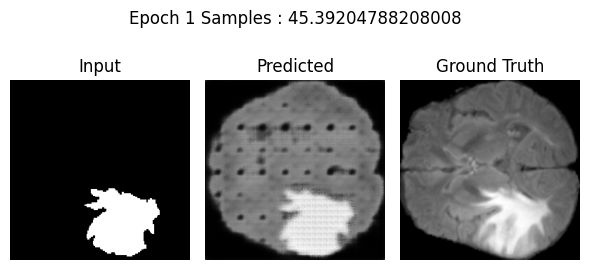

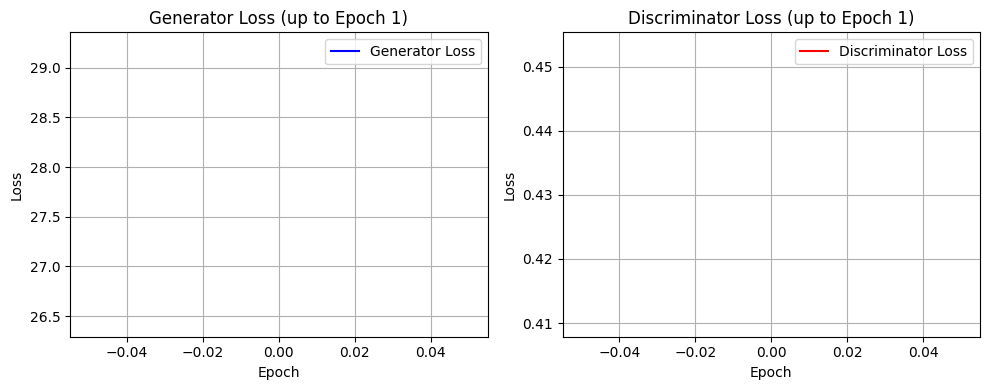


Validation | MSE: 0.1334
Best model saved.
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 2/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 2 : 16.344627380371094

Validation | MSE: 0.1618
Best model saved.
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 3/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 3 : 27.3385066986084

Validation | MSE: 0.1381
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 4/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 4 : 23.806015014648438


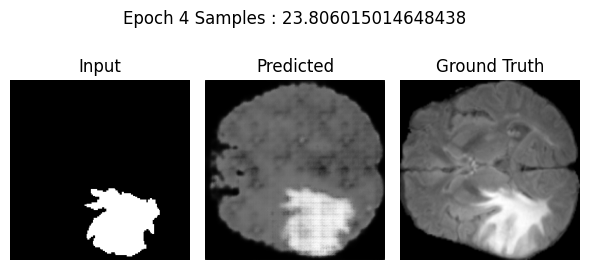

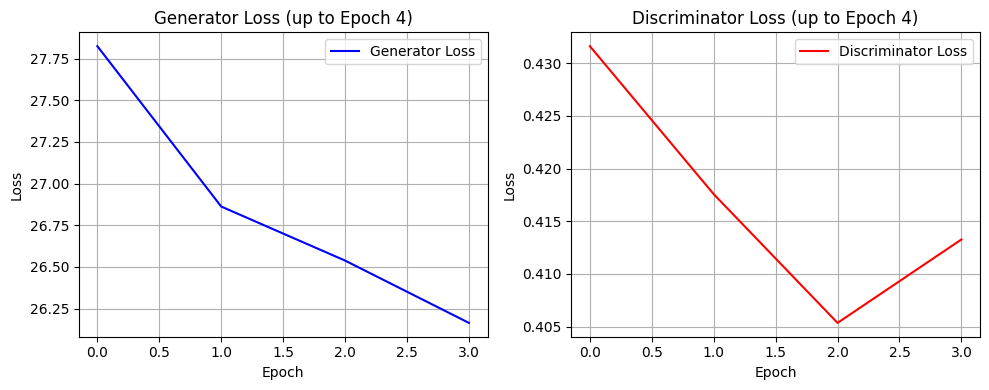


Validation | MSE: 0.1270
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 5/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 5 : 20.23712158203125

Validation | MSE: 0.1398
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 6/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 6 : 15.962784767150879

Validation | MSE: 0.1623
Best model saved.
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 7/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 7 : 21.912811279296875


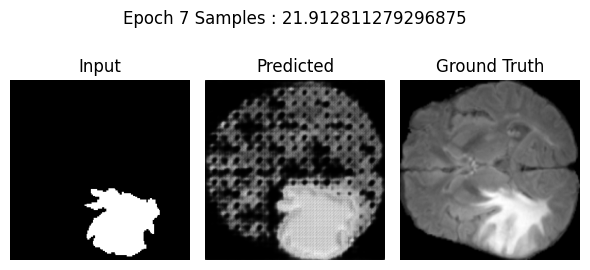

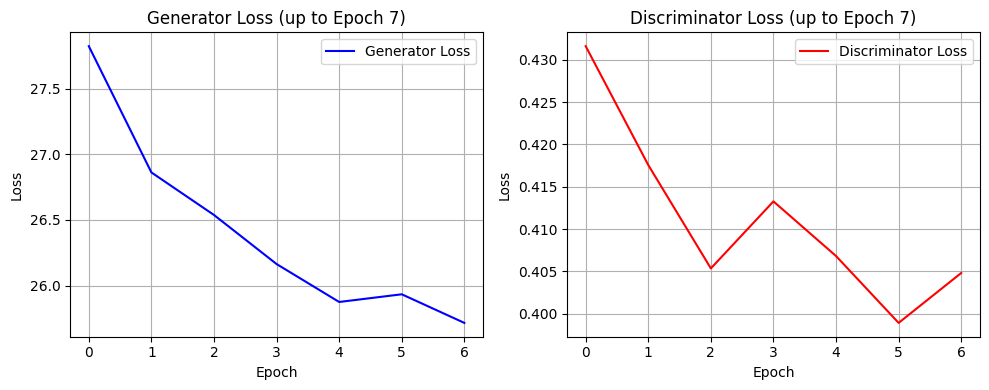


Validation | MSE: 0.3092
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 8/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 8 : 18.007312774658203

Validation | MSE: 0.1374
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 9/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 9 : 16.57299041748047

Validation | MSE: 0.1433
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 10/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 10 : 25.768306732177734


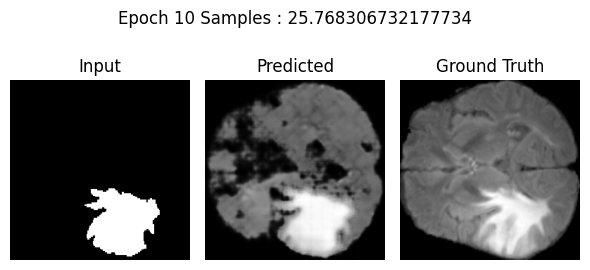

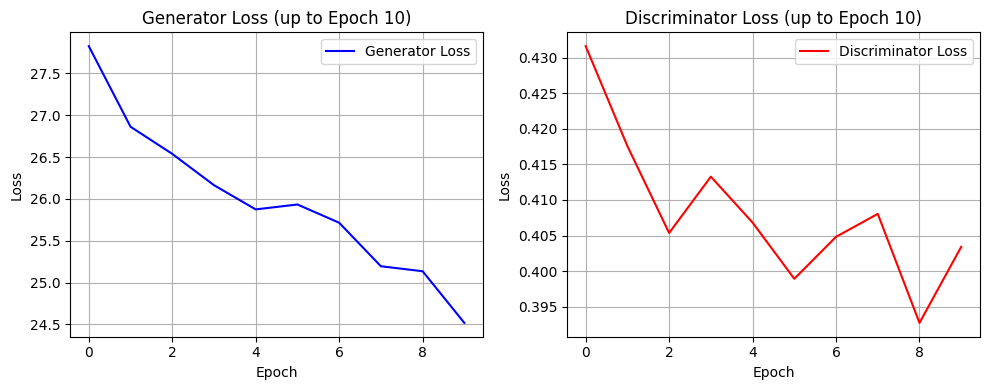


Validation | MSE: 0.1734
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 11/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 11 : 28.388986587524414

Validation | MSE: 0.1353
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 12/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 12 : 17.806156158447266

Validation | MSE: 0.1827
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 13/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 13 : 16.128910064697266


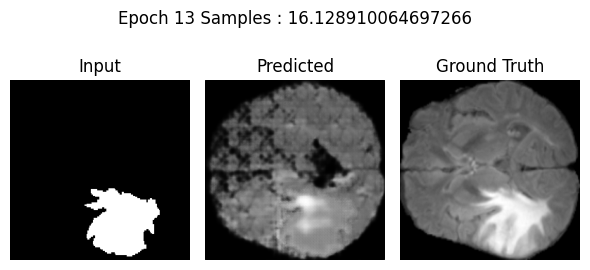

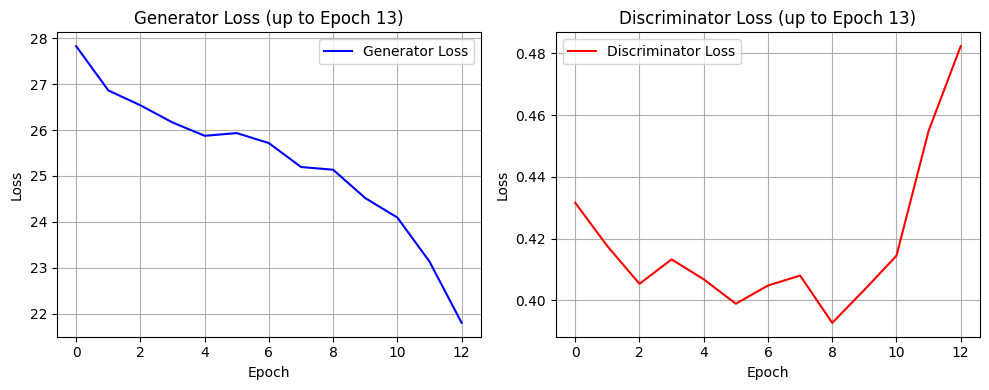


Validation | MSE: 0.1475
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 14/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 14 : 14.626932144165039

Validation | MSE: 0.1504
Best model saved.
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 15/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 15 : 18.397836685180664

Validation | MSE: 0.1729
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 16/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 16 : 13.160417556762695


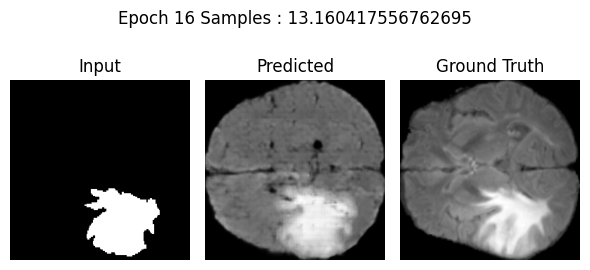

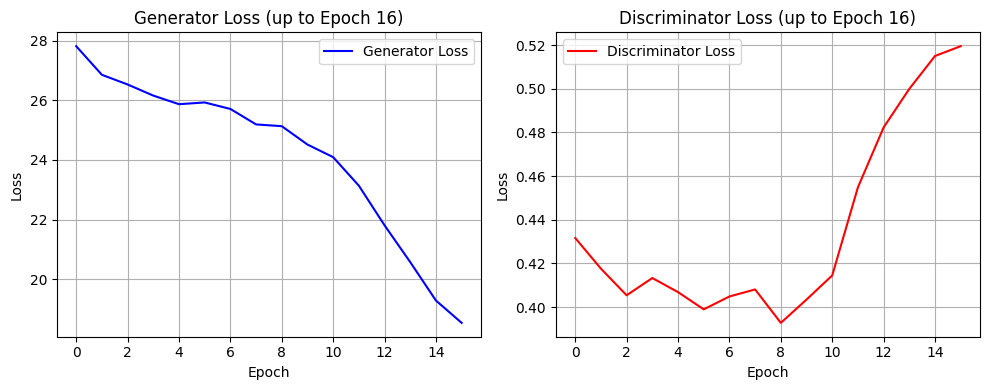


Validation | MSE: 0.1357
Best model saved.
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 17/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 17 : 16.070945739746094

Validation | MSE: 0.1566
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 18/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 18 : 17.77090072631836

Validation | MSE: 0.1480
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 19/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 19 : 14.361886978149414


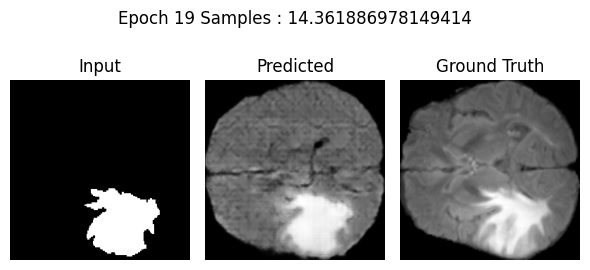

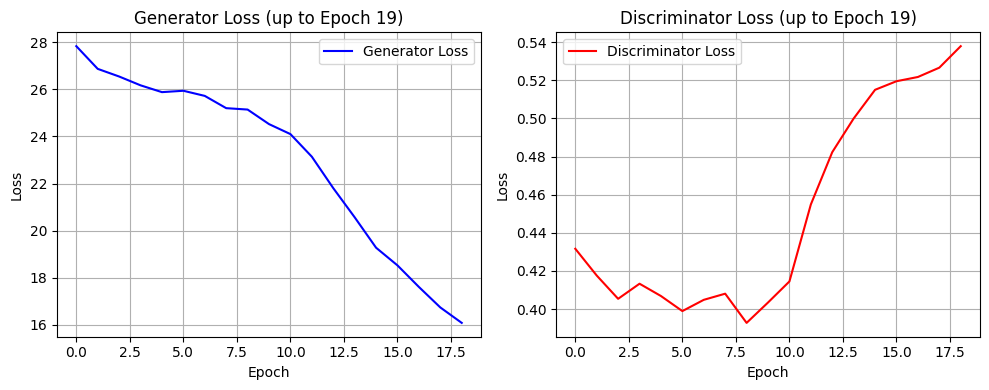


Validation | MSE: 0.1274
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 20/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 20 : 15.116233825683594

Validation | MSE: 0.1262
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 21/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 21 : 15.188643455505371

Validation | MSE: 0.1506
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 22/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 22 : 11.608318328857422


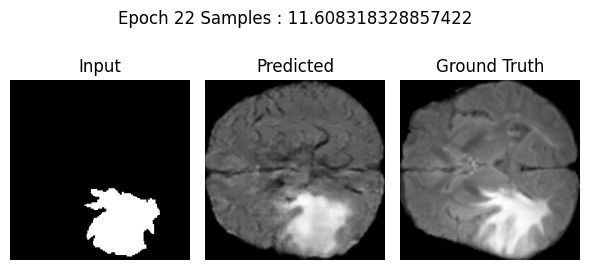

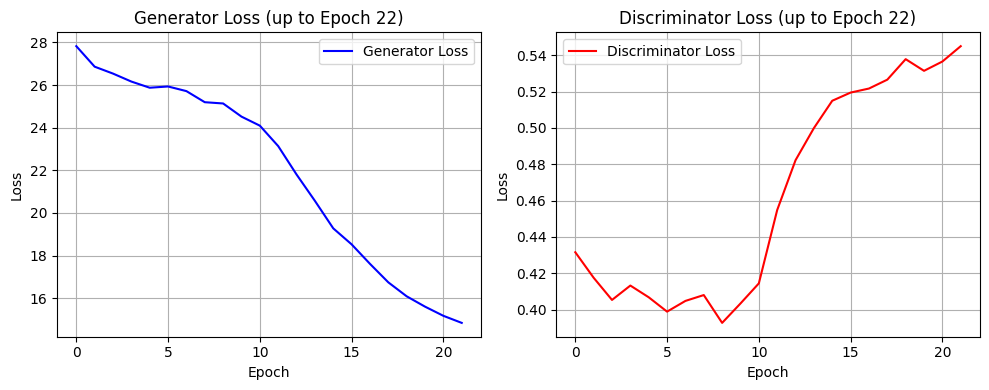


Validation | MSE: 0.1270
Best model saved.
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 23/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 23 : 14.199301719665527

Validation | MSE: 0.1269
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 24/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 24 : 14.56233024597168

Validation | MSE: 0.1276
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 25/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 25 : 12.498138427734375


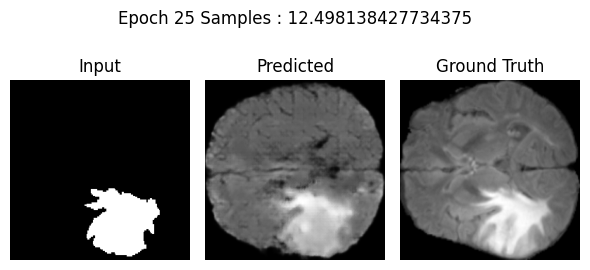

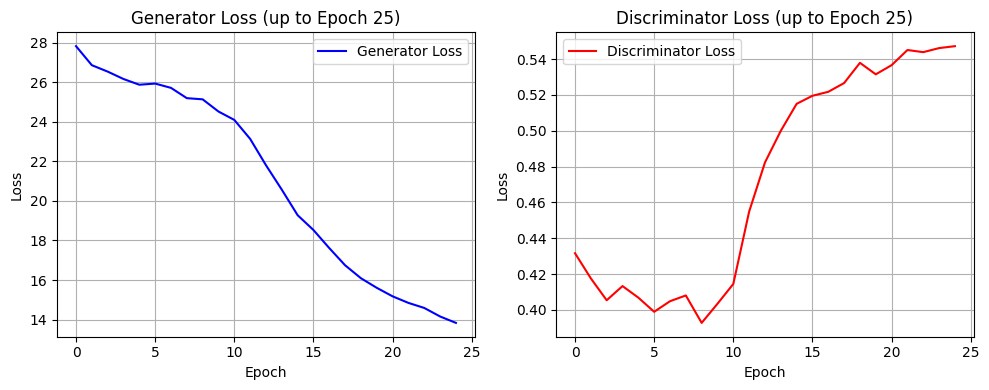


Validation | MSE: 0.1195
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 26/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 26 : 14.392077445983887

Validation | MSE: 0.1367
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 27/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 27 : 13.17773723602295

Validation | MSE: 0.1190
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 28/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 28 : 9.920153617858887


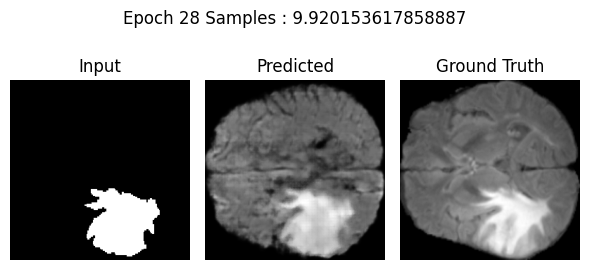

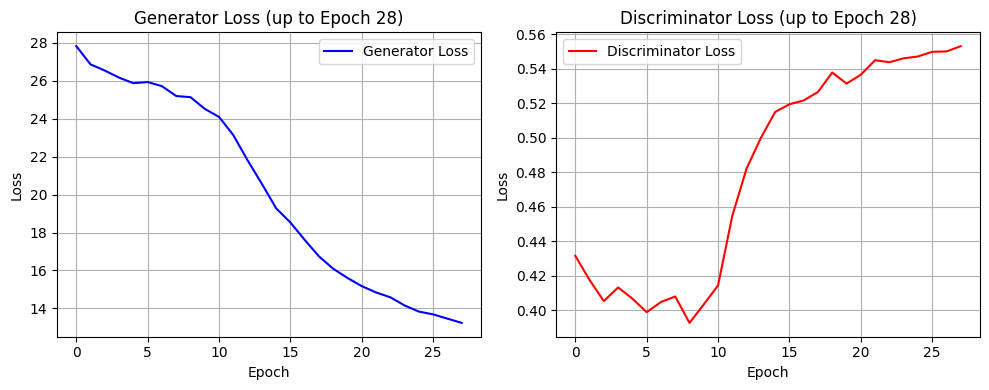


Validation | MSE: 0.1428
Best model saved.
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 29/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 29 : 11.809624671936035

Validation | MSE: 0.1337
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 30/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 30 : 12.865681648254395

Validation | MSE: 0.1348
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 31/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 31 : 11.403751373291016


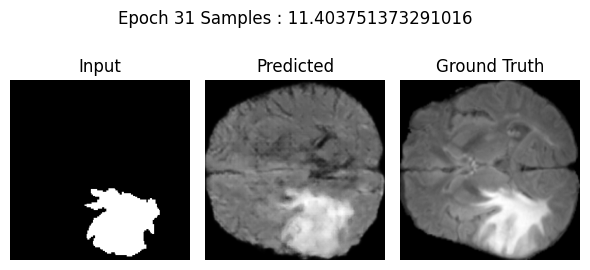

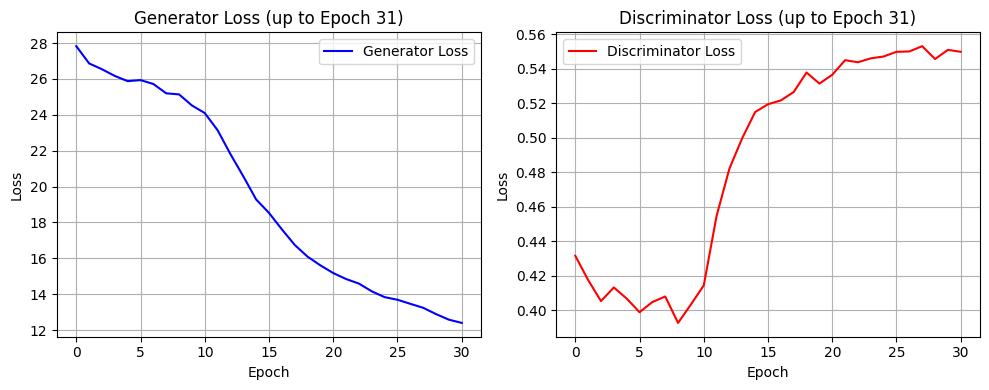


Validation | MSE: 0.1215
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 32/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 32 : 12.70283317565918

Validation | MSE: 0.1345
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 33/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 33 : 10.956855773925781

Validation | MSE: 0.1263
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 34/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 34 : 13.998391151428223


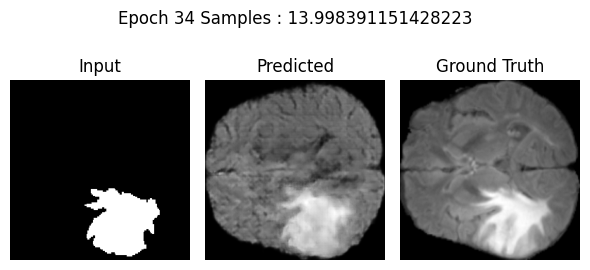

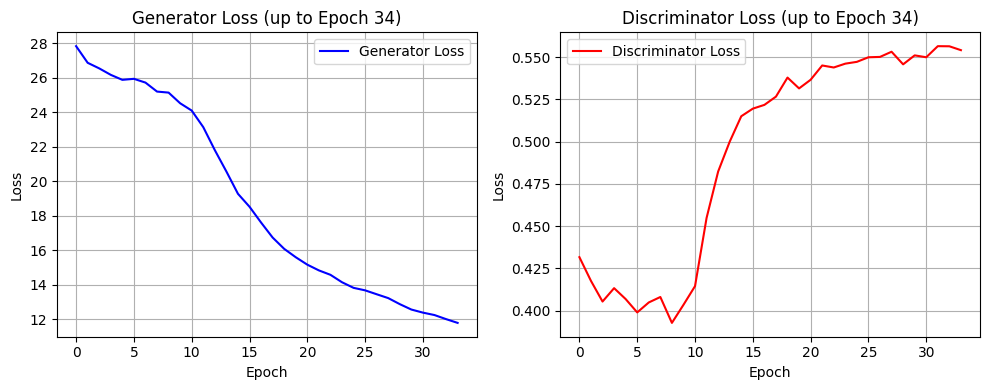


Validation | MSE: 0.1217
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 35/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 35 : 12.338282585144043

Validation | MSE: 0.1235
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 36/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 36 : 11.01341724395752

Validation | MSE: 0.1106
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 37/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 37 : 12.019426345825195


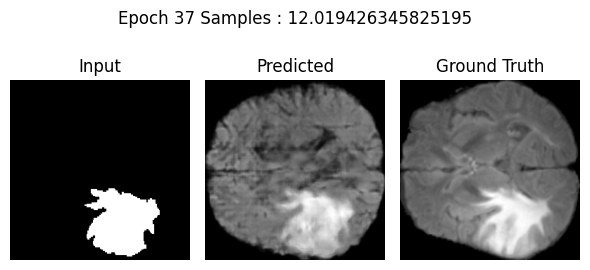

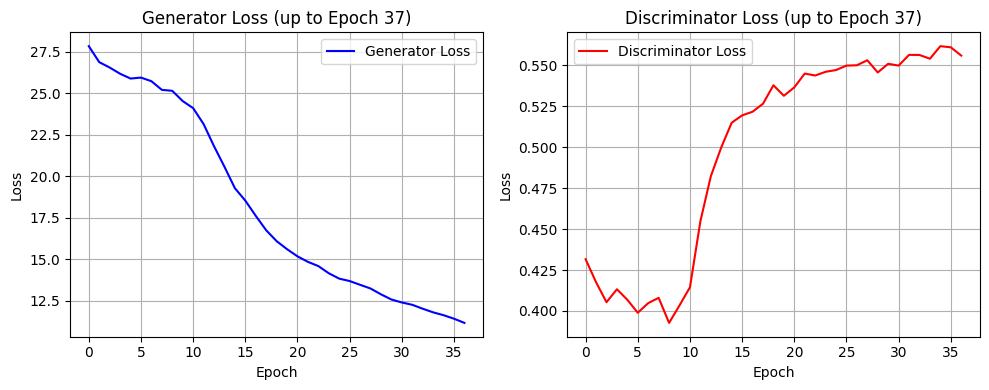


Validation | MSE: 0.1268
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 38/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 38 : 10.316656112670898

Validation | MSE: 0.1220
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 39/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 39 : 12.250994682312012

Validation | MSE: 0.1189
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 40/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 40 : 8.748441696166992


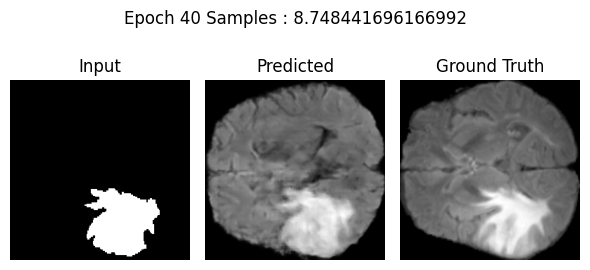

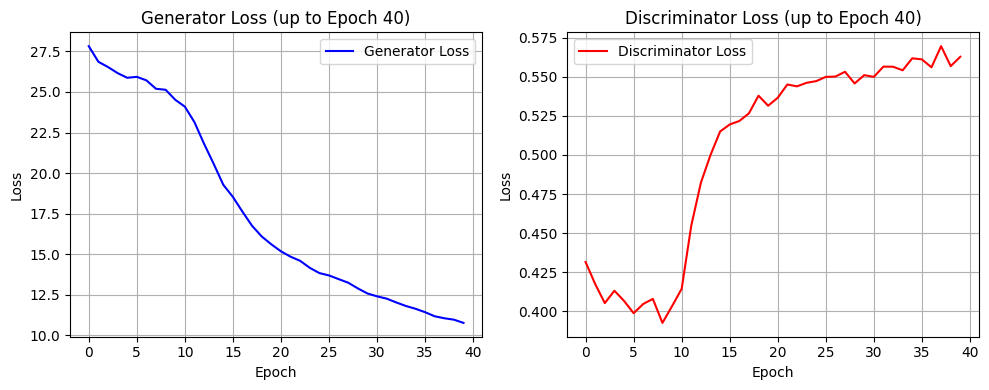


Validation | MSE: 0.1230
Best model saved.
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 41/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 41 : 9.246071815490723

Validation | MSE: 0.1113
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 42/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 42 : 9.759706497192383

Validation | MSE: 0.1156
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 43/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 43 : 11.083182334899902


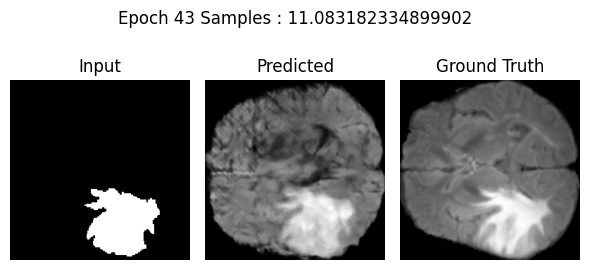

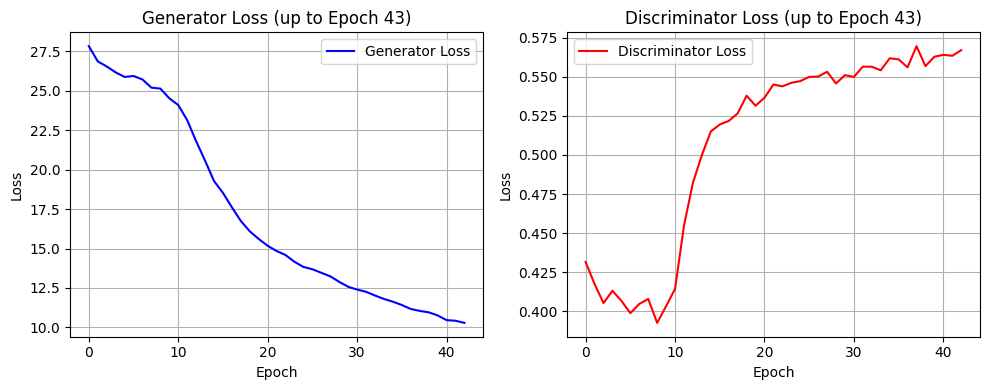


Validation | MSE: 0.1223
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 44/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 44 : 9.474859237670898

Validation | MSE: 0.1235
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 45/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 45 : 8.7665433883667

Validation | MSE: 0.1237
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 46/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 46 : 8.489053726196289


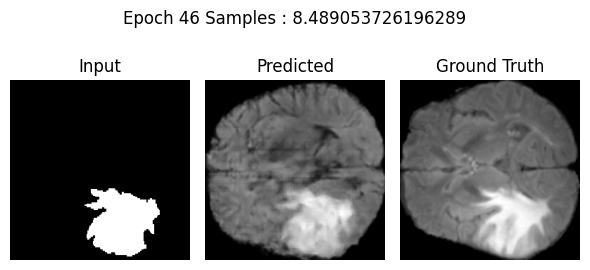

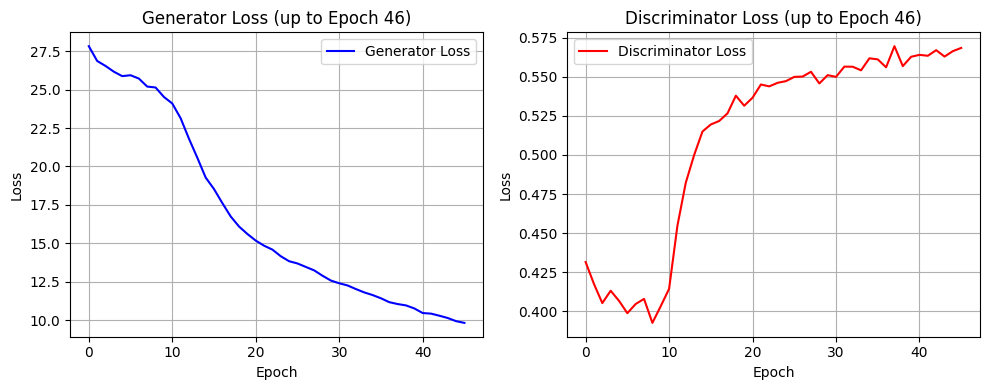


Validation | MSE: 0.1201
Best model saved.
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 47/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 47 : 12.785441398620605

Validation | MSE: 0.1147
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 48/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 48 : 9.070070266723633

Validation | MSE: 0.1253
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 49/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 49 : 7.790575981140137


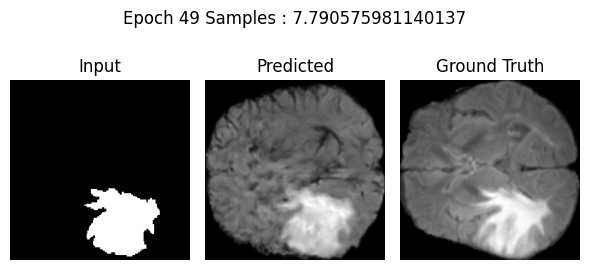

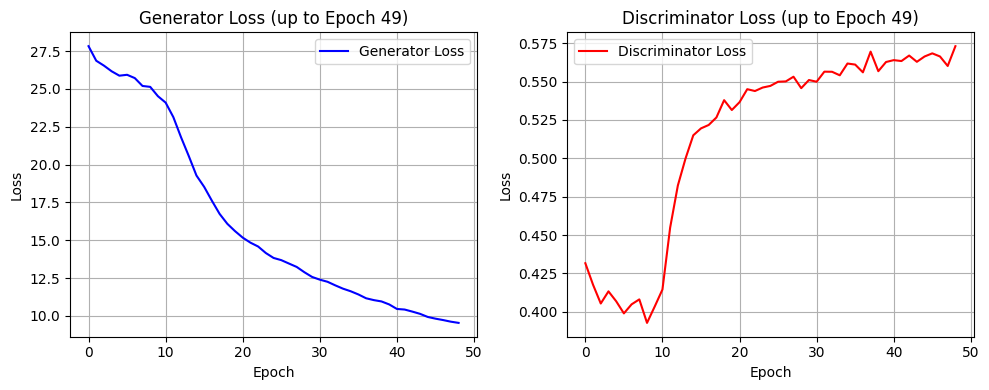


Validation | MSE: 0.1205
Best model saved.
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 50/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 50 : 8.485095977783203

Validation | MSE: 0.1215
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 51/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 51 : 8.546544075012207

Validation | MSE: 0.1240
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 52/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 52 : 8.684215545654297


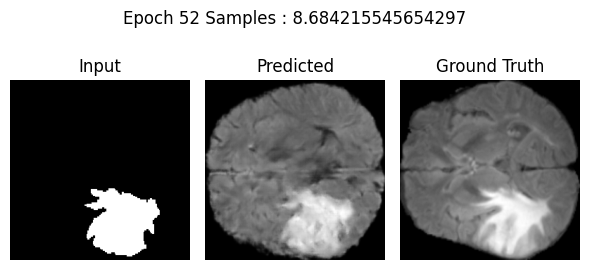

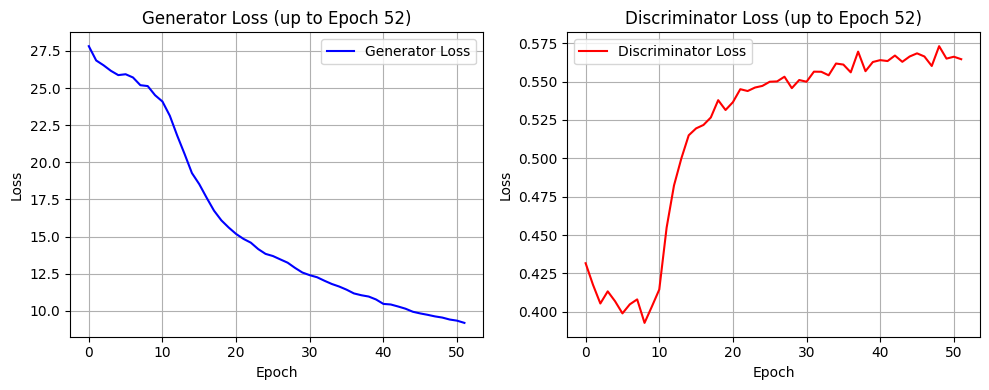


Validation | MSE: 0.1113
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 53/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 53 : 8.274115562438965

Validation | MSE: 0.1199
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 54/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 54 : 8.703983306884766

Validation | MSE: 0.1177
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 55/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 55 : 9.27536392211914


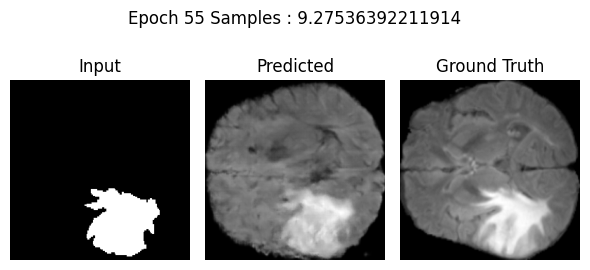

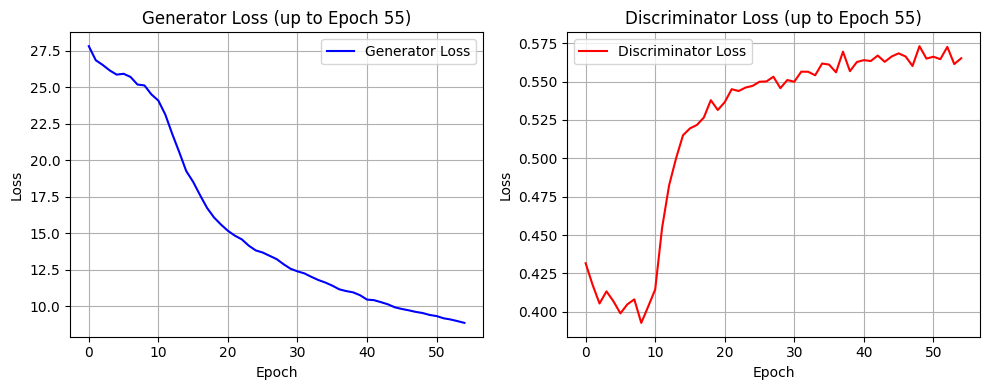


Validation | MSE: 0.1080
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 56/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 56 : 11.357643127441406

Validation | MSE: 0.1152
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 57/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 57 : 9.654674530029297

Validation | MSE: 0.1167
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 58/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 58 : 28.071483612060547


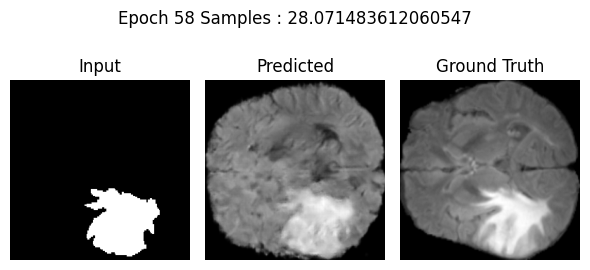

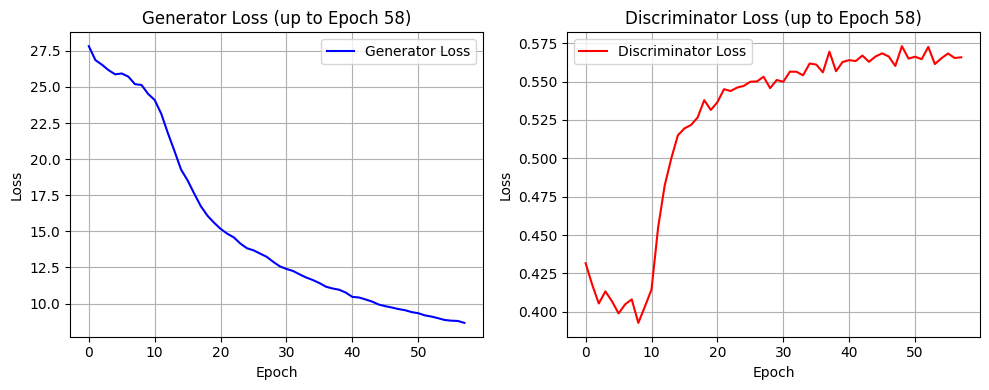


Validation | MSE: 0.1136
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 59/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 59 : 8.893917083740234

Validation | MSE: 0.1180
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 60/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 60 : 7.435176849365234

Validation | MSE: 0.1171
Best model saved.
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 61/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 61 : 11.027379989624023


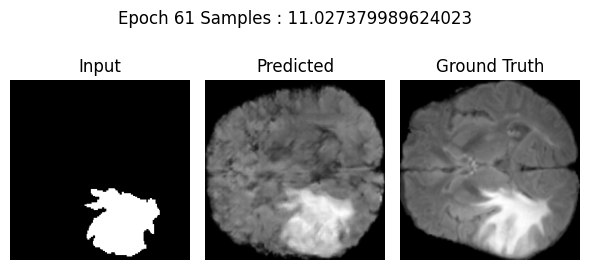

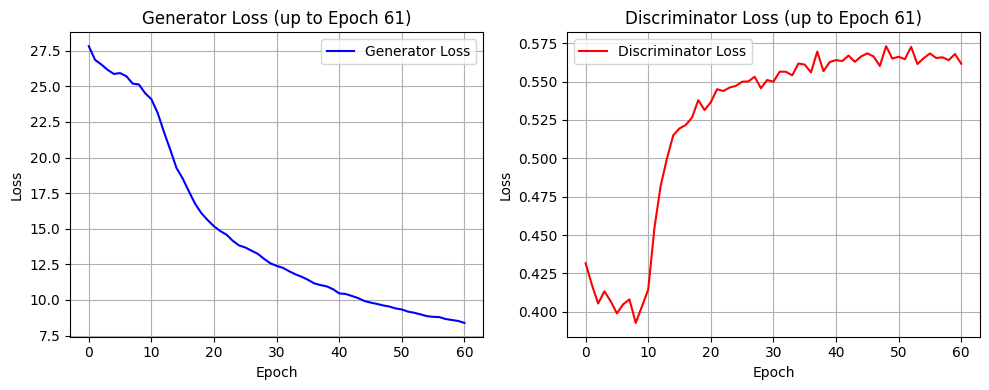


Validation | MSE: 0.1159
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 62/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 62 : 8.880778312683105

Validation | MSE: 0.1149
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 63/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 63 : 6.647718906402588

Validation | MSE: 0.1128
Best model saved.
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 64/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 64 : 7.733956336975098


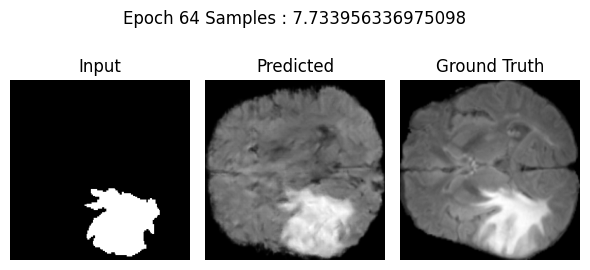

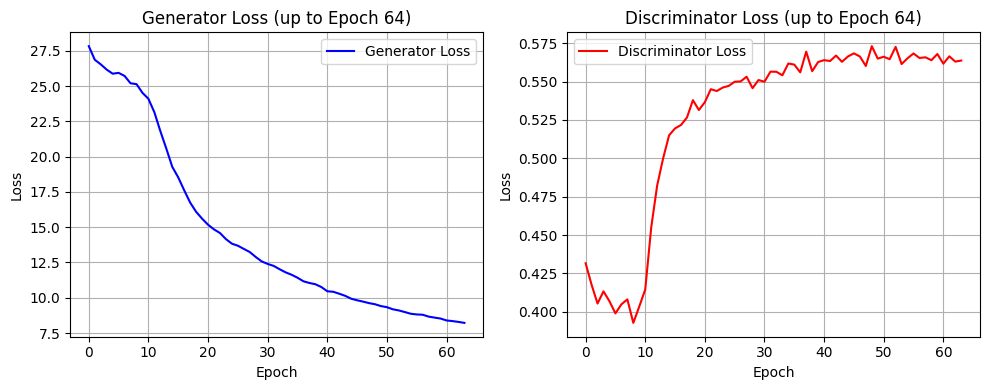


Validation | MSE: 0.1163
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 65/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 65 : 7.041787147521973

Validation | MSE: 0.1194
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 66/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 66 : 8.50846004486084

Validation | MSE: 0.1160
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 67/150:   0%|          | 0/451 [00:00<?, ?it/s]


G_loss for 67 : 7.285740375518799


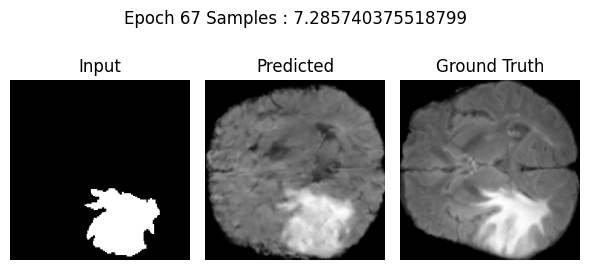

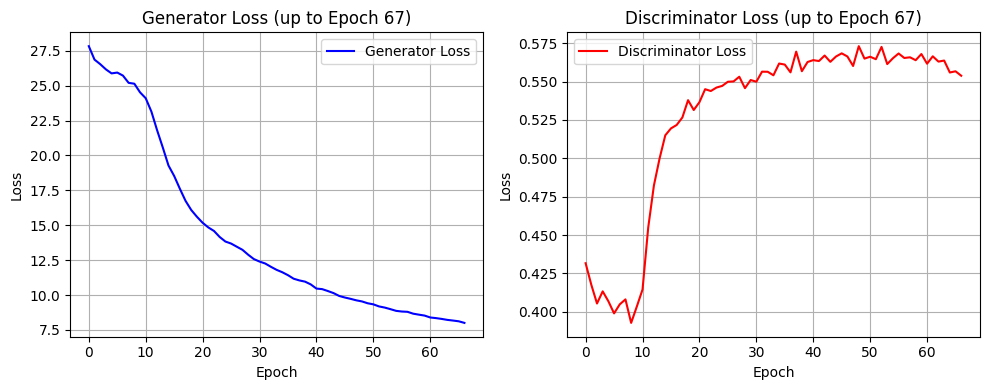


Validation | MSE: 0.1103
------------------------------------------------------------------------------------------------------------------------------------------------------


Epoch 68/150:   0%|          | 0/451 [00:00<?, ?it/s]

In [ ]:
LOAD_MODEL = False  # or False, depending if you want to resume
LOAD_MODEL_PATH = "/kaggle/input/checkpoint_epoch_24_mask2mri/pytorch/default/1/checkpoint_epoch_24.pth"

# === Weight Initialization ===
generator.apply(init_weights_gaussian)
discriminator.apply(init_weights_gaussian)

# === Resume Setup ===
loss_history = {"g_loss": [], "d_loss": [], "mse": []}
start_epoch = 0
least_loss = 999

if LOAD_MODEL and os.path.exists(LOAD_MODEL_PATH):
    checkpoint = torch.load(LOAD_MODEL_PATH, map_location=DEVICE)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
    d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
    start_epoch = checkpoint['epoch']

# === Training Loop ===
for epoch in range(start_epoch, NUM_EPOCHS):
    generator.train()
    discriminator.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    running_g_loss = running_d_loss = running_mse = 0

    for batch_idx, (y, x) in enumerate(pbar):
        x, y = x.to(DEVICE), y.to(DEVICE)

        # === Discriminator Step ===
        fake_y = generator(x)
        real_out = discriminator(x, y)
        fake_out = discriminator(x, fake_y.detach())

        d_loss_real = criterion_GAN(real_out, torch.ones_like(real_out))
        d_loss_fake = criterion_GAN(fake_out, torch.zeros_like(fake_out))
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Generator Step ===
        fake_out = discriminator(x, fake_y)
        adv_loss = criterion_GAN(fake_out, torch.ones_like(fake_out))
        recon_loss = l1_loss(fake_y, y)
        g_loss = adv_loss + LAMBDA_L1 * recon_loss

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # === Metrics ===
        mse = mse_loss(fake_y, y)

        running_g_loss += g_loss.item()
        running_d_loss += d_loss.item()
        running_mse += mse.item()
        
        pbar.set_postfix({
            "D_Loss": f"{running_d_loss / (batch_idx+1):.4f}",
            "G_Loss": f"{running_g_loss / (batch_idx+1):.4f}",
            "MSE":    f"{running_mse / (batch_idx+1):.4f}",
        })

    
    print(f"\nG_loss for {epoch+1} : {g_loss}")
    # === Save Sample Outputs ===
    generator.eval()
    val_batch = next(iter(val_loader))
    val_x, val_y = val_batch[1].to(DEVICE), val_batch[0].to(DEVICE)
    with torch.no_grad():
        val_preds = generator(val_x)

    if((epoch+3)%3 == 0):
        show_samples(val_x[:4].cpu(), val_preds[:4].cpu(), val_y[:4].cpu(), epoch, g_loss)

    # === Validation ===
    val_dice, val_iou, val_mse = [], [], []
    with torch.no_grad():
        for y_val, x_val in val_loader:
            x_val, y_val = x_val.to(DEVICE), y_val.to(DEVICE)
            y_pred = generator(x_val)
            val_mse.append(mse_loss(y_pred, y_val).item())

    avg_mse = sum(val_mse) / len(val_mse)

    loss_history["mse"].append(avg_mse)
    loss_history["g_loss"].append(running_g_loss / len(train_loader))
    loss_history["d_loss"].append(running_d_loss / len(train_loader))

    if((epoch+3)%3 == 0):
        plot_current_losses(loss_history["g_loss"], loss_history["d_loss"], epoch)


    print(f"\nValidation | MSE: {avg_mse:.4f}")

    # === Save Best Model (MSE) ===
    if g_loss < least_loss:
        least_loss = g_loss
        torch.save({
            'epoch': epoch+1,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'g_optimizer_state_dict': g_optimizer.state_dict(),
            'd_optimizer_state_dict': d_optimizer.state_dict(),
        }, os.path.join(MODEL_SAVE_DIR, "best_mask2mri_checkpoint.pth"))
        print("Best model saved.")

    print("-" * 150)

print("Training complete.")


In [ ]:
def visualize_preprocessed_cropped(patient_id, base_dir="/kaggle/input/cropped-images"):
    image_dir = os.path.join(base_dir, "images")
    mask_dir = os.path.join(base_dir, "masks")

    image_files = sorted([f for f in os.listdir(image_dir) if f.startswith(f"{patient_id}_slice_")])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.startswith(f"{patient_id}_slice_")])

    if not image_files:
        print(f"No slices found for patient ID {patient_id}")
        return

    for i in range(0, len(image_files), 10):  # Show every 10th slice
        img_path = os.path.join(image_dir, image_files[i])
        mask_path = os.path.join(mask_dir, mask_files[i])

        flair = np.load(img_path)
        mask = np.load(mask_path)

        fig, ax = plt.subplots(1, 2, figsize=(5,5))
        ax[0].imshow(flair, cmap="viridis")
        ax[0].set_title(f"Flair")
        ax[0].axis("off")

        ax[1].imshow(mask, cmap="viridis")
        ax[1].set_title(f"Mask")
        ax[1].axis("off")

        plt.tight_layout()
        plt.show()

# Example usage:
visualize_preprocessed_cropped("BraTS20_Training_083")


# Data Augmentation

In [199]:
class AugmentedBrainMRIDataset(Dataset):
    def __init__(self, train_dataset, generator_checkpoint_path, device='cpu', num_aug=2):
        self.train_dataset = train_dataset
        self.img_dir = self.train_dataset.image_dir
        self.mask_dir = self.train_dataset.mask_dir
        
        self.device = device
        self.num_aug = num_aug

        self.image_files = train_dataset.image_names.copy()
        self.mask_files = train_dataset.mask_names.copy()

        assert len(self.image_files) == len(self.mask_files), "Image and mask count mismatch"

        # Load best generator model
        self.generator = UNetGenerator(in_channels=1, out_channels=1).to(self.device)
        checkpoint = torch.load(generator_checkpoint_path, map_location=self.device, weights_only=True)
        self.generator.load_state_dict(checkpoint["generator_state_dict"])

    def __len__(self):
        return len(self.image_files) * (self.num_aug + 1)  # original + augmented versions

    def _generate_augmented_pairs(self, mask : Image) -> torch.Tensor:
        mask = transforms.Compose([
            transforms.RandomRotation(degrees=35),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip()
        ])(mask)
        mask_np = np.array(mask.resize((256, 256), Image.BILINEAR))
        mask_tensor = torch.from_numpy(mask_np).unsqueeze(0).unsqueeze(0).float().to(self.device)

        with torch.no_grad():
            gen_image = self.generator(mask_tensor)

        # Normalize from [-1, 1] to [0, 1]
        gen_image = (gen_image + 1) / 2.0
        gen_image = gen_image * 255
        mask_tensor = mask_tensor / 255
        return gen_image.squeeze(1), mask_tensor.squeeze(1)
        

                
        
    
    def __getitem__(self, idx):
        original_idx = idx // (self.num_aug + 1)  # to get corresponding original image index
        aug_idx = idx % (self.num_aug + 1)  # to get augmentation number
        
        img_path = os.path.join(self.img_dir, self.image_files[original_idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[original_idx])
        def npToPIL(arr: np.ndarray) -> Image:
            arr = (255 * arr).astype(np.uint8)
            return Image.fromarray(arr).convert("L")
        image = npToPIL(np.load(img_path))
        mask = npToPIL(np.load(mask_path))
        
        if aug_idx == 0:
            image = self.train_dataset.image_transform(image)
            mask = self.train_dataset.mask_transform(mask)
        else:
            image, mask = self._generate_augmented_pairs(mask)

        # print(f"image : {image.min()},{image.max()}")
        # print(f"mask : {mask.min()},{mask.max()}")
        return image, mask

    def show_sample(self, idx):
        """Display original and 5 augmented versions of an image-mask pair."""
        original_idx = idx // (self.num_aug + 1)  # to get corresponding original index
        
        fig, axes = plt.subplots(2, self.num_aug + 1, figsize=(15, 6))
        titles = ["Original Image"] + [f"Augmented {i}" for i in range(1, self.num_aug + 1)]
        
        for aug_idx in range(self.num_aug + 1):
            sample_img, sample_mask = self.__getitem__(original_idx * (self.num_aug + 1) + aug_idx)
            #print(f"sample_img type: {type(sample_img)}")
            sample_img = sample_img.squeeze().cpu().detach().numpy()
            #print(f"sample_mask type: {type(sample_mask)}")
            sample_mask = sample_mask.squeeze().cpu().detach().numpy()
            
            axes[0, aug_idx].imshow(sample_img, cmap='gray')
            axes[0, aug_idx].set_title(titles[aug_idx])
            axes[0, aug_idx].axis("off")
            
            axes[1, aug_idx].imshow(sample_mask, cmap='gray')
            axes[1, aug_idx].set_title(titles[aug_idx])
            axes[1, aug_idx].axis("off")

        plt.suptitle("Original & Augmented Images and Masks")
        plt.show()

In [200]:
# class AugmentedBrainMRIDataset(Dataset):
#     def __init__(self, train_dataset, generator_checkpoint_path, device='cpu', num_aug=2):
#         self.img_dir = train_dataset.image_dir
#         self.mask_dir = train_dataset.mask_dir
#         self.device = device
#         self.num_aug = num_aug

#         self.image_files = train_dataset.image_names.copy()
#         self.mask_files = train_dataset.mask_names.copy()

#         assert len(self.image_files) == len(self.mask_files), "Image and mask count mismatch"

#         # Load best generator model
#         self.generator = UNetGenerator(in_channels=1, out_channels=1).to(self.device)
#         checkpoint = torch.load(generator_checkpoint_path, map_location=self.device, weights_only=True)
#         self.generator.load_state_dict(checkpoint["generator_state_dict"])
#         self.generator.eval()

#         self._generate_augmented_pairs()

#     def _generate_augmented_pairs(self):
#         for idx in tqdm(range(len(self.mask_files)), desc="Generating synthetic images"):
#             mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
#             mask_np = np.load(mask_path)
#             mask_np = np.resize(mask_np, (256,256))
#             mask_tensor = torch.from_numpy(mask_np).unsqueeze(0).unsqueeze(0).float().to(self.device)

#             for i in range(1, self.num_aug + 1):
#                 with torch.no_grad():
#                     gen_image = self.generator(mask_tensor)[0].cpu().numpy()

#                 # Normalize from [-1, 1] to [0, 1]
#                 gen_image = (gen_image + 1) / 2.0
#                 gen_image = np.clip(gen_image, 0, 1).squeeze()

#                 base_filename = os.path.splitext(self.image_files[idx])[0]
#                 image_filename = f"{base_filename}_gen{i}.npy"
#                 mask_filename = f"{base_filename}_gen{i}.npy"

#                 np.save(os.path.join(self.img_dir, image_filename), gen_image)
#                 np.save(os.path.join(self.mask_dir, mask_filename), mask_np)

#                 self.image_files.append(image_filename)
#                 self.mask_files.append(mask_filename)

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.image_files[idx])
#         mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

#         image = np.load(img_path)
#         mask = np.load(mask_path)

#         image = torch.from_numpy(image).unsqueeze(0).float()  # shape: [1, H, W]
#         mask = torch.from_numpy(mask).unsqueeze(0).float()

#         return image, mask

#     def show_sample(self, idx):
#         original_idx = idx // (self.num_aug + 1)
#         fig, axes = plt.subplots(2, self.num_aug + 1, figsize=(15, 6))
#         titles = ["Original Image"] + [f"Augmented {i}" for i in range(1, self.num_aug + 1)]

#         for aug_idx in range(self.num_aug + 1):
#             i = original_idx * (self.num_aug + 1) + aug_idx
#             image, mask = self.__getitem__(i)
#             image_np = image.squeeze().numpy()
#             mask_np = mask.squeeze().numpy()

#             axes[0, aug_idx].imshow(image_np, cmap='gray')
#             axes[0, aug_idx].set_title(titles[aug_idx])
#             axes[0, aug_idx].axis("off")

#             axes[1, aug_idx].imshow(mask_np, cmap='gray')
#             axes[1, aug_idx].axis("off")

#         plt.suptitle("Original & Augmented Images and Masks")
#         plt.tight_layout()
#         plt.show()


In [201]:

augmented_dataset = AugmentedBrainMRIDataset(
    train_dataset=train_dataset,
    generator_checkpoint_path="/kaggle/input/best_mask2mri_checkpoint.pth/pytorch/default/1/best_mask2mri_checkpoint.pth",
    device=DEVICE,
    num_aug=4
)

train_loader = DataLoader(augmented_dataset, batch_size=1, shuffle=True)

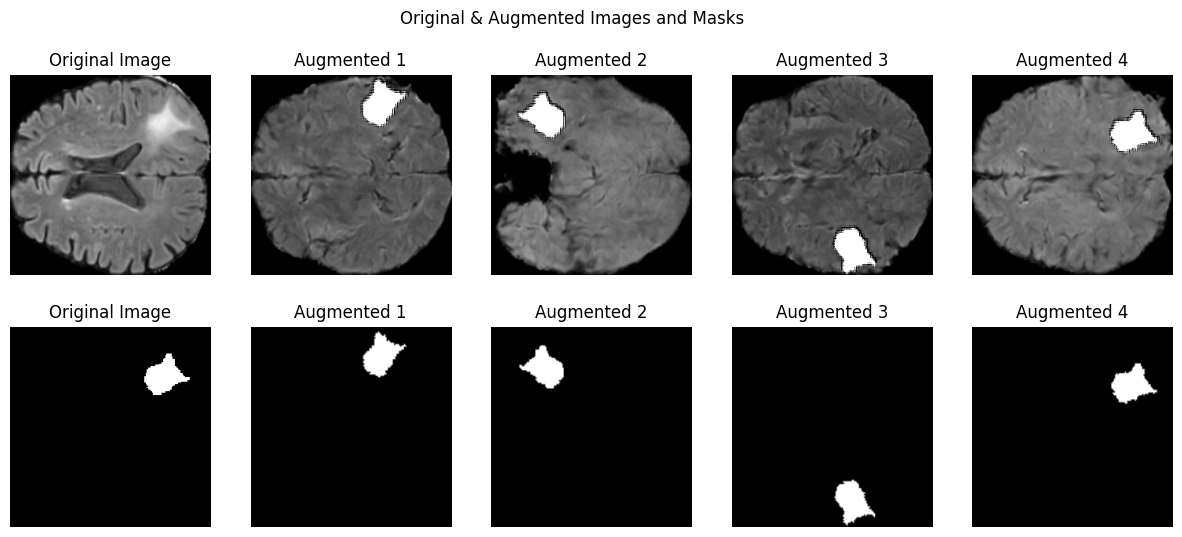

In [202]:
train_loader.dataset.show_sample(5)

# Model

In [138]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi
        
class AttentionUNET(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256]):
        super(AttentionUNET, self).__init__()
        self.out_channels = out_channels
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.attentions = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.attentions.append(AttentionBlock(F_g=feature, F_l=feature, F_int=feature // 2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] #reverse list

        for idx in range(0, len(self.ups), 2):  #do up and double_conv
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            skip_connection = self.attentions[idx // 2](skip_connection, x)
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3,1, 512, 512)).to(DEVICE)
    model = AttentionUNET(in_channels=1, out_channels=1).to(DEVICE)
    preds = model(x)
    print(f"Test shape = {x.shape}")
    print(f"Prediction shape = {preds.shape}")
    summary(model, (1, 512, 512))

if __name__ == "__main__":
    test()

Test shape = torch.Size([3, 1, 512, 512])
Prediction shape = torch.Size([3, 1, 512, 512])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             288
       BatchNorm2d-2         [-1, 32, 512, 512]              64
              ReLU-3         [-1, 32, 512, 512]               0
            Conv2d-4         [-1, 32, 512, 512]           9,216
       BatchNorm2d-5         [-1, 32, 512, 512]              64
              ReLU-6         [-1, 32, 512, 512]               0
        DoubleConv-7         [-1, 32, 512, 512]               0
         MaxPool2d-8         [-1, 32, 256, 256]               0
            Conv2d-9         [-1, 64, 256, 256]          18,432
      BatchNorm2d-10         [-1, 64, 256, 256]             128
             ReLU-11         [-1, 64, 256, 256]               0
           Conv2d-12         [-1, 64, 256, 256]          36,864
      BatchNo

# Training

In [203]:
# # Hyperparameters
# LEARNING_RATE = 1e-4
# BATCH_SIZE = 16
# NUM_EPOCHS = 20
# LOAD_MODEL = False
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# # function to save model checkpoint
# def save_checkpoint(state, filename="my_attention_checkpoint.pth.tar"):
#     print("=> Saving checkpoint")
#     torch.save(state, filename)

# # function to load model checkpoint
# def load_checkpoint(checkpoint, model):
#     print("=> Loading checkpoint")
#     model.load_state_dict(checkpoint["state_dict"])

# # function to calculate IoU
# def calculate_iou(preds, targets):
#     intersection = (preds * targets).sum()
#     union = preds.sum() + targets.sum() - intersection
#     return intersection / (union + 1e-8)  # Adding epsilon to avoid division by zero

# # function to check accuracy, return Dice score, IoU score & validation loss
# def check_accuracy(loader, model, loss_fn, device="cuda"):
#     num_correct = 0
#     num_pixels = 0
#     dice_score = 0
#     iou_score = 0  # IoU tracking
#     total_loss = 0
#     model.eval()

#     with torch.no_grad():
#         for x, y in loader:
#             x = x.to(device)
#             y = y.to(device)

#             logits = model(x)  # Raw logits (no sigmoid yet)
#             loss = loss_fn(logits, y)  # Compute loss before thresholding
#             total_loss += loss.item()

#             preds = torch.sigmoid(logits)  # Convert logits to probabilities
#             preds_bin = (preds > 0.5).float()  # Thresholding after loss

#             num_correct += (preds_bin == y).sum().item()
#             num_pixels += torch.numel(preds_bin)
#             dice_score += (2 * (preds_bin * y).sum()) / ((preds_bin + y).sum() + 1e-8)
#             iou_score += calculate_iou(preds_bin, y)  # Compute IoU

#             pl

#     avg_loss = total_loss / len(loader)  # Compute average validation loss
#     avg_dice = dice_score / len(loader)  # Compute average Dice score
#     avg_iou = iou_score / len(loader)  # Compute average IoU score

#     print(f"Accuracy: {num_correct}/{num_pixels} ({num_correct / num_pixels * 100:.2f}%)")
#     print(f"Dice Score: {avg_dice:.4f}")
#     print(f"IoU Score: {avg_iou:.4f}")  # Print IoU score

#     model.train()
#     return avg_dice, avg_iou, avg_loss

# # function to save predictions as images (Restored Original Version)
# def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda"):
#     os.makedirs(folder, exist_ok=True)
#     model.eval()
#     for idx, (x, y) in enumerate(loader):
#         x = x.to(device=device)
#         with torch.no_grad():
#             preds = torch.sigmoid(model(x))
#             preds = (preds > 0.5).float()
#         torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.png")
#         torchvision.utils.save_image(y, f"{folder}/gt_{idx}.png")
#     model.train()

# # function to train model
# def train_fn(loader, model, optimizer, loss_fn, scaler, val_loader):
#     loop = tqdm(loader, desc="Training", leave=True)
#     total_loss = 0
#     val_loss = 0  # To store validation loss
    
#     for batch_idx, (data, targets) in enumerate(loop):
#         data = data.to(device=DEVICE)
#         targets = targets.float().to(device=DEVICE)
#         # print(f"data : {data.min()},{data.max()}")
#         # print(f"targets : {targets.min()},{targets.max()}")
#         # break

#         # Forward
#         with torch.amp.autocast('cuda'):
#             predictions = model(data)
#             loss = loss_fn(predictions, targets)
#             total_loss += loss.item()  # Add loss for this batch

#         # Backward
#         optimizer.zero_grad()
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         # Compute validation loss on one batch for quick monitoring
#         with torch.no_grad():
#             val_data, val_targets = next(iter(val_loader))  # Get a validation batch
#             val_data, val_targets = val_data.to(DEVICE), val_targets.to(DEVICE)
        
#             val_logits = model(val_data)  # Get raw outputs
#             val_loss = loss_fn(val_logits, val_targets).item()  # Compute loss directly on logits
        
#             # Convert logits to probabilities AFTER loss calculation
#             val_preds = torch.sigmoid(val_logits)
#             val_preds = (val_preds > 0.5).float()

#         # Update tqdm loop to display training and validation loss
#         loop.set_postfix(train_loss=loss.item(), val_loss=val_loss)
    
#     return total_loss / len(loader)  # return average training loss


# def main():
#     print(f"Device used : {DEVICE}")
#     model = AttentionUNET(in_channels=1, out_channels=1).to(DEVICE)
#     loss_fn = nn.BCEWithLogitsLoss()
#     optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#     if LOAD_MODEL:
#         load_checkpoint(torch.load("my_attention_checkpoint.pth.tar"), model)

#     check_accuracy(val_loader, model,loss_fn, device=DEVICE)
#     scaler = torch.amp.GradScaler('cuda')

#     best_dice_score = 0  # Track the best Dice score
#     best_iou_score = 0 # Track the best IoU score
#     best_checkpoint = None  # Store the best checkpoint
#     train_losses = []  # List to store training losses
#     val_losses = []  # List to store validation losses
#     iou_scores = []  # List to store IoU scores

#     for epoch in range(NUM_EPOCHS):
#         print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
        
#         train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler,val_loader)
#         train_losses.append(train_loss)  # store training loss
        
#         # validate and get Dice score, IoU, and val loss
#         dice_score, iou_score, val_loss = check_accuracy(val_loader, model, loss_fn, device=DEVICE)
#         val_losses.append(val_loss)  # store validation loss
#         iou_scores.append(iou_score)  # store IoU score

#         # Save model if Dice score improves
#         if (dice_score+iou_score)/2 > (best_dice_score+best_iou_score)/2:
#             best_dice_score = dice_score
#             best_iou_score = iou_score
#             best_checkpoint = {
#                 "state_dict": model.state_dict(),
#                 "optimizer": optimizer.state_dict(),
#             }
#             save_checkpoint(best_checkpoint)  # Save the best checkpoint

#         # if Dice score stops improving, break training
#         elif (dice_score+iou_score)/2 == (best_dice_score+best_iou_score)/2:
#             print("Stopping early as average Dice+IoU score did not improve.")
#             break

#         # to save some sample predictions
#         save_predictions_as_imgs(val_loader, model, folder="saved_images/", device=DEVICE)

#     print("Training Complete. \nBest Dice Score:", best_dice_score)
#     print("Best IoU Score:", best_iou_score)

#     # to save final best checkpoint after training ends
#     if best_checkpoint:
#         save_checkpoint(best_checkpoint, filename="best_attention_model.pth.tar")

#     # to save losses and IoU scores for later use
#     np.save("train_losses.npy", np.array(train_losses))
#     np.save("val_losses.npy", np.array(val_losses))
#     np.save("iou_scores.npy", np.array([score.cpu().item() for score in iou_scores]))# Save IoU scores

# if __name__ == "__main__":
#     main()

Device used : cuda
Accuracy: 3847600/44498944 (8.65%)
Dice Score: 0.1536
IoU Score: 0.0865

Epoch 1/20


Training:   0%|          | 0/2255 [00:00<?, ?it/s]

Accuracy: 40651344/44498944 (91.35%)
Dice Score: 0.0000
IoU Score: 0.0000
Stopping early as average Dice+IoU score did not improve.
Training Complete. 
Best Dice Score: 0
Best IoU Score: 0


Device used : cuda
Accuracy: 3847600/44498944 (8.65%)
Dice Score: 0.1536
IoU Score: 0.0865

Epoch 1/20


Training:   0%|          | 0/2255 [00:00<?, ?it/s]

Accuracy: 40651344/44498944 (91.35%)
Dice Score: 0.0000
IoU Score: 0.0000


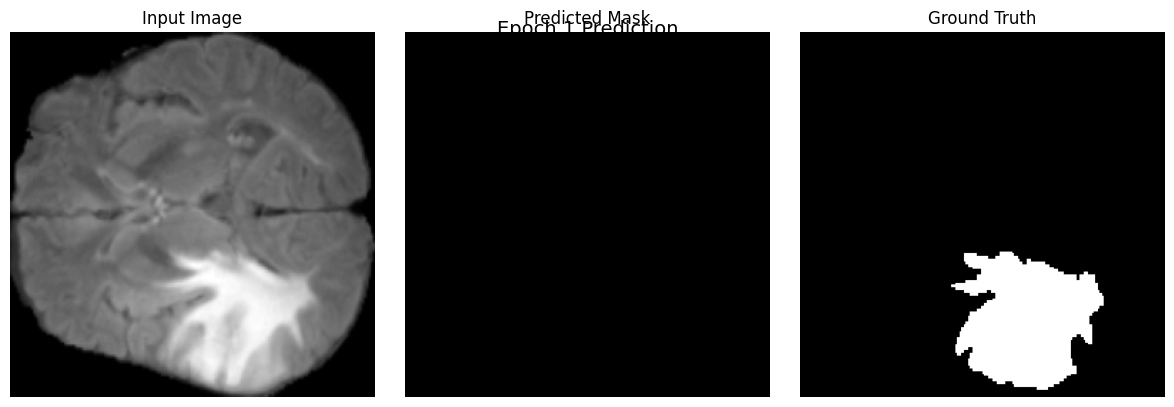


Epoch 2/20


Training:   0%|          | 0/2255 [00:00<?, ?it/s]

Accuracy: 40651344/44498944 (91.35%)
Dice Score: 0.0000
IoU Score: 0.0000


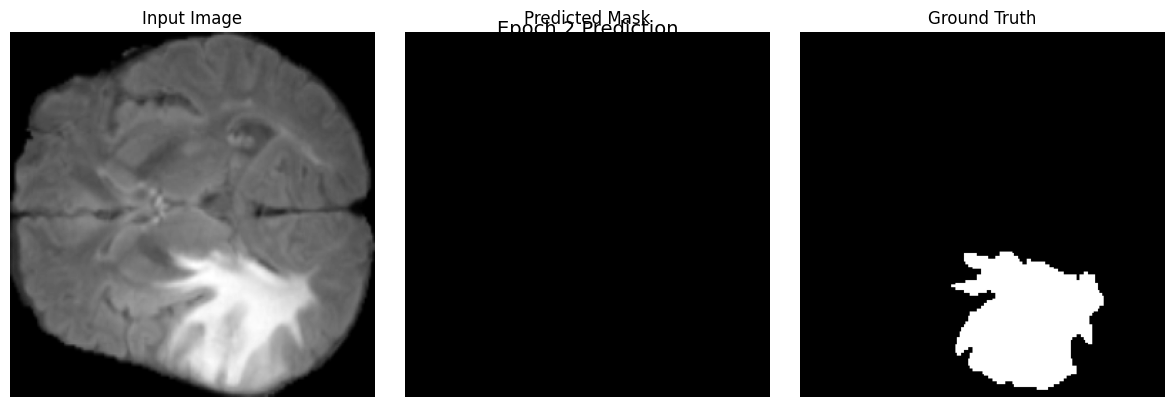


Epoch 3/20


Training:   0%|          | 0/2255 [00:00<?, ?it/s]

Accuracy: 40651344/44498944 (91.35%)
Dice Score: 0.0000
IoU Score: 0.0000


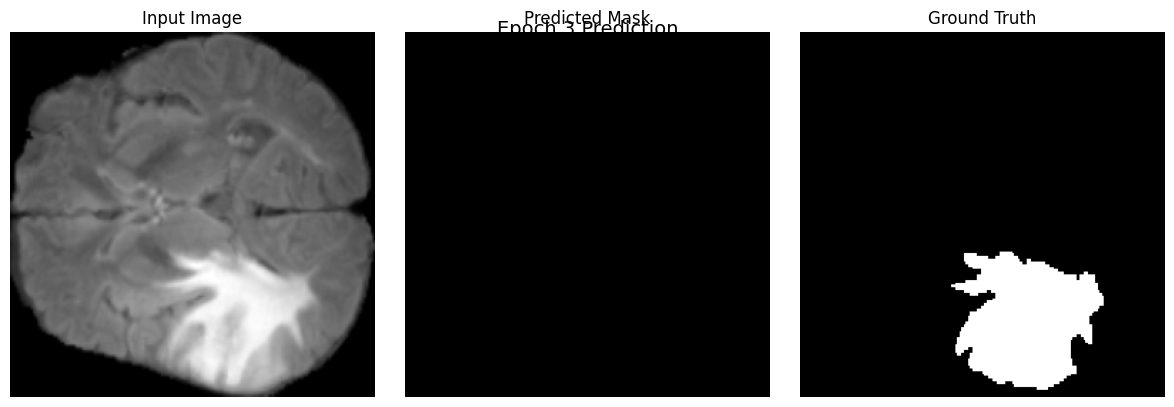


Epoch 4/20


Training:   0%|          | 0/2255 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [211]:
# Hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
NUM_EPOCHS = 20
LOAD_MODEL = False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# function to save model checkpoint
def save_checkpoint(state, filename="my_attention_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

# function to load model checkpoint
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

# function to calculate IoU
def calculate_iou(preds, targets):
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return intersection / (union + 1e-8)  # Adding epsilon to avoid division by zero

# function to check accuracy, return Dice score, IoU score & validation loss
def check_accuracy(loader, model, loss_fn, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    iou_score = 0  # IoU tracking
    total_loss = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)  # Raw logits (no sigmoid yet)
            loss = loss_fn(logits, y)  # Compute loss before thresholding
            total_loss += loss.item()

            preds = torch.sigmoid(logits)  # Convert logits to probabilities
            preds_bin = (preds > 0.5).float()  # Thresholding after loss

            num_correct += (preds_bin == y).sum().item()
            num_pixels += torch.numel(preds_bin)
            dice_score += (2 * (preds_bin * y).sum()) / ((preds_bin + y).sum() + 1e-8)
            iou_score += calculate_iou(preds_bin, y)  # Compute IoU

    avg_loss = total_loss / len(loader)  # Compute average validation loss
    avg_dice = dice_score / len(loader)  # Compute average Dice score
    avg_iou = iou_score / len(loader)  # Compute average IoU score

    print(f"Accuracy: {num_correct}/{num_pixels} ({num_correct / num_pixels * 100:.2f}%)")
    print(f"Dice Score: {avg_dice:.4f}")
    print(f"IoU Score: {avg_iou:.4f}")  # Print IoU score

    model.train()
    return avg_dice, avg_iou, avg_loss

# function to save predictions as images (Restored Original Version)
def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda"):
    os.makedirs(folder, exist_ok=True)
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.png")
        torchvision.utils.save_image(y, f"{folder}/gt_{idx}.png")
    model.train()

# NEW: plot single prediction after each epoch
def plot_single_prediction(model, loader, device, epoch):
    model.eval()
    with torch.no_grad():
        x, y = next(iter(loader))
        x, y = x.to(device), y.to(device)
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()

        image = x[0].cpu().squeeze()
        pred = preds[0].cpu().squeeze()
        gt = y[0].cpu().squeeze()

        fig, axs = plt.subplots(1, 3, figsize=(9, 3))
        axs[0].imshow(image, cmap="gray")
        axs[0].set_title("Input Image")
        axs[1].imshow(pred, cmap="gray")
        axs[1].set_title("Predicted Mask")
        axs[2].imshow(gt, cmap="gray")
        axs[2].set_title("Ground Truth")

        for ax in axs:
            ax.axis("off")
        plt.tight_layout()
        plt.suptitle(f"Epoch {epoch + 1} Prediction")
        plt.show()  # <- Display the plot instead of saving
    model.train()

# function to train model
def train_fn(loader, model, optimizer, loss_fn, scaler, val_loader):
    loop = tqdm(loader, desc="Training", leave=True)
    total_loss = 0
    val_loss = 0  # To store validation loss
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().to(device=DEVICE)

        # Forward
        with torch.amp.autocast('cuda'):
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            total_loss += loss.item()  # Add loss for this batch

        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Compute validation loss on one batch for quick monitoring
        with torch.no_grad():
            val_data, val_targets = next(iter(val_loader))  # Get a validation batch
            val_data, val_targets = val_data.to(DEVICE), val_targets.to(DEVICE)
        
            val_logits = model(val_data)  # Get raw outputs
            val_loss = loss_fn(val_logits, val_targets).item()  # Compute loss directly on logits
        
            # Convert logits to probabilities AFTER loss calculation
            val_preds = torch.sigmoid(val_logits)
            val_preds = (val_preds > 0.5).float()

        # Update tqdm loop to display training and validation loss
        loop.set_postfix(train_loss=loss.item(), val_loss=val_loss)
    
    return total_loss / len(loader)  # return average training loss


def main():
    print(f"Device used : {DEVICE}")
    model = AttentionUNET(in_channels=1, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_attention_checkpoint.pth.tar"), model)

    check_accuracy(val_loader, model, loss_fn, device=DEVICE)
    scaler = torch.amp.GradScaler('cuda')

    best_dice_score = 0  # Track the best Dice score
    best_iou_score = 0  # Track the best IoU score
    best_checkpoint = None  # Store the best checkpoint
    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    iou_scores = []  # List to store IoU scores

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
        
        train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler, val_loader)
        train_losses.append(train_loss)  # store training loss
        
        # validate and get Dice score, IoU, and val loss
        dice_score, iou_score, val_loss = check_accuracy(val_loader, model, loss_fn, device=DEVICE)
        val_losses.append(val_loss)  # store validation loss
        iou_scores.append(iou_score)  # store IoU score

        # NEW: save single prediction plot
        plot_single_prediction(model, val_loader, DEVICE, epoch)

        # Save model if Dice score improves
        if (dice_score + iou_score) / 2 > (best_dice_score + best_iou_score) / 2:
            best_dice_score = dice_score
            best_iou_score = iou_score
            best_checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(best_checkpoint)  # Save the best checkpoint

        # if Dice score stops improving, break training
        # elif (dice_score + iou_score) / 2 == (best_dice_score + best_iou_score) / 2:
        #     print("Stopping early as average Dice+IoU score did not improve.")
        #     break

        # to save some sample predictions
        save_predictions_as_imgs(val_loader, model, folder="saved_images/", device=DEVICE)

    print("Training Complete. \nBest Dice Score:", best_dice_score)
    print("Best IoU Score:", best_iou_score)

    # to save final best checkpoint after training ends
    if best_checkpoint:
        save_checkpoint(best_checkpoint, filename="best_attention_model.pth.tar")

    # to save losses and IoU scores for later use
    np.save("train_losses.npy", np.array(train_losses))
    np.save("val_losses.npy", np.array(val_losses))
    np.save("iou_scores.npy", np.array([score.cpu().item() for score in iou_scores]))  # Save IoU scores


if __name__ == "__main__":
    main()


### Graphs

In [ ]:
train_losses = np.load("train_losses.npy")
val_losses = np.load("val_losses.npy")
iou_scores = np.load("iou_scores.npy")

print(f"Train Losses : {np.array(train_losses)}")
print(f"Validation Losses : {np.array(val_losses)}")
print(f"Train Losses : {np.array(iou_scores)}")

In [ ]:
train_losses = np.load("train_losses.npy")
val_losses = np.load("val_losses.npy")
iou_scores = np.load("iou_scores.npy")

plt.figure(figsize=(10,5))

# training & validation loss
plt.subplot(1,2,1)
plt.plot(train_losses, label="Training Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

# IoU scores
plt.subplot(1,2,2)
plt.plot(iou_scores, label="IoU Score", color='green')
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.legend()
plt.title("IoU Score Over Epochs")

plt.show()


# Training prediction batch-wise visualization

In [ ]:
saved_images_path = "saved_images/"

saved_images = sorted(os.listdir(saved_images_path))

fig, axes = plt.subplots(10, 2, figsize=(20, 20))

for i in range(10):
    pred_path = os.path.join(saved_images_path, f"pred_{i+10}.png")
    pred_mask_path = os.path.join(saved_images_path, f"gt_{i+10}.png")  # Ground truth mask

    pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    mask_img = cv2.imread(pred_mask_path, cv2.IMREAD_GRAYSCALE)

    if pred_img is None:
        print(f"Warning: {pred_path} not found!")
        continue
    if mask_img is None:
        print(f"Warning: {pred_mask_path} not found!")
        continue

    axes[i, 0].imshow(mask_img, cmap="gray")
    axes[i, 0].set_title(f"Ground Truth {i+10}")
    axes[i, 0].axis("off")
    
    axes[i, 1].imshow(pred_img, cmap="gray")
    axes[i, 1].set_title(f"Prediction {i+10}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

# Predict any image from test dataset

In [ ]:
# Load trained model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize UNET model (Ensure UNET class is defined/imported before this)
model = AttentionUNET(in_channels=1, out_channels=1).to(DEVICE)

# Load the checkpoint from Kaggle dataset
checkpoint_path = "/kaggle/input/attentionunet-dummy/pytorch/default/1/best_attention_model.pth.tar" #when using downloaded
checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=True)

# Load model state
model.load_state_dict(checkpoint["state_dict"])
model.eval()

# Define Preprocessing Transform
val_test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

def predict_single_image(img_path, mask_path, model):
    """
    Given an image path, this function returns the original image, 
    predicted mask, and ground truth mask.
    """
    # load original image & mask
    image = Image.open(img_path).convert("L")  # Convert to grayscale
    mask = Image.open(mask_path).convert("L")  # Convert to grayscale
    
    # transform image
    input_tensor = val_test_transform(image).unsqueeze(0).to(DEVICE)  # Add batch dimension

    # model prediction
    with torch.no_grad():
        pred_mask = torch.sigmoid(model(input_tensor))
        pred_mask = (pred_mask > 0.5).float()

    # convert Tensors to Numpy
    original_np = np.array(image.resize((256,256)))
    pred_mask_np = pred_mask.cpu().squeeze().numpy()
    inv_pred_mask_np = (pred_mask_np > 0.5)
    inv_pred_mask_np = np.where(pred_mask_np == 1, 0, 255)
    mask_np = val_test_transform(mask).cpu().squeeze().numpy()

    # create Cropped Tumor Image (White background, only tumor visible)
    tumor_only = np.where(pred_mask_np == 1,original_np,255)

    # IoU (Intersection over Union) Calculation
    intersection = np.logical_and(pred_mask_np, mask_np).sum()
    union = np.logical_or(pred_mask_np, mask_np).sum()
    iou_score = intersection / (union + 1e-7)  # Add small value to avoid division by zero

    # Dice Score Calculation
    dice_score = (2 * intersection) / (pred_mask_np.sum() + mask_np.sum() + 1e-7)  # Avoid division by zero

    print(f"IoU Score: {iou_score:.4f}")
    print(f"Dice Score: {dice_score:.4f}")
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    titles = ["Original Image", "Ground Truth Mask", "Predicted Mask","Tumor Cropped"]
    images = [original_np, mask_np, inv_pred_mask_np, tumor_only]

    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="gray")
        ax.set_title(titles[i])
        ax.axis("off")

    plt.show()

In [ ]:
# -----------------------
# Test on a sample image
# -----------------------

# choose a random test image and mask
rand_idx = random.randint(0, len(test_imgs) - 1)
img_name = test_imgs[rand_idx]
mask_name = test_masks[rand_idx]

img_path_test = os.path.join(image_path, img_name)
mask_path_test = os.path.join(mask_path, mask_name)

print(f"Testing on random image: {img_name}")
print("Image path : ", img_path_test)
print("Mask path : ", mask_path_test)

predict_single_image(img_path_test, mask_path_test, model)

<function matplotlib.pyplot.show(close=None, block=None)>

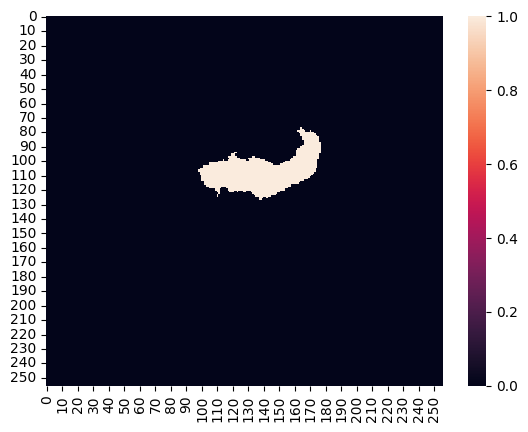

In [11]:
import seaborn as sns
sns.heatmap(np.load("/kaggle/input/brats-preprocessed-256/training/masks/BraTS20_Training_001_slice_100.npy"))
plt.show